In [32]:
import numpy as np
import pandas as pd
from scipy import stats

%matplotlib inline

import matplotlib.pyplot as plt

In [33]:
planets = pd.read_csv('exoplanets.csv')
planets.shape

(517, 6)

## Independence and Conditional Independence

*In progress*

## Approximate Inference and Sampling, Part 1

### Why we need posterior distributions

In general, we need the posterior distribution so that we can make statements and decisions about our unknown quantity of interest, $\theta$. We saw that for simple models like the product review model or the model for heights, it was easy to compute the posterior exactly, because we chose a conjugate prior.

In the product review example:
* Our parameter of interest $\theta$ represents the probability of a positive review.
* If we chose a Beta prior, i.e., $\theta \sim \mathrm{Beta}(\alpha, \beta)$, then the posterior distribution also belonged to the Beta family: $\theta | x \sim \mathrm{Beta}(\alpha + \sum x_i, \beta + n - \sum x_i)$.
* This made it easy to determine things like the MAP estimate or LMSE estimate, simply by using known properties of the Beta distribution.

But what if our posterior distribution didn't have such a convenient form? In that case, we would have to compute the posterior (and any estimates from it) ourselves:

\begin{align}
p(\theta|x)
&= \frac{p(x|\theta)p(\theta)}{p(x)} \\
&= \frac{p(x|\theta)p(\theta)}{\int p(x|\theta)p(\theta)\,d\theta} \\
\end{align}

In general, the integral in the denominator could be impossible to compute. We call the denominator the **normalizing constant**: it's a constant because it doesn't depend on $\theta$, and it's normalizing because we need it for the distribution or density to sum or integrate to 1. 

In the next section, we'll see a few examples that illustrate why computing the normalizing constant is hard, but first, let's examine why we need to know it in the first place.

#### MAP Estimation 

Suppose we want to compute the MAP estimate:
\begin{align}
\hat{\theta}_{MAP} 
&= \underset{\theta}{\operatorname{argmax}} p(\theta|x) \\
&= \underset{\theta}{\operatorname{argmax}} \frac{p(x|\theta)p(\theta)}{p(x)} \\
&= \underset{\theta}{\operatorname{argmax}} p(x|\theta)p(\theta) \\
\end{align}

In the last step, we used the fact that p(x) doesn't depend on $\theta$.

If $\theta$ is low-dimensional and continuous, we can easily optimize this either analytically or sometimes numerically. If $\theta$ is discrete and doesn't take on too many different values, we can search over all possible values. However, if $\theta$ is discrete and takes on an intractably large number of possible values, then we'd need to search over all of them, which would be impossible.

To summarize: for low-dimensional continuous variables, or discrete random variables with a low number of possible values, we can compute the MAP estimate without needing to know the exact posterior. For higher-dimensional random variables and/or discrete random variables with many possible values, this won't work.

#### LMSE Estimation
Suppose we want to compute the LMSE estimate. Recall the definition of conditional expectation (see Data 140 textbook, [Chapter 9](http://prob140.org/textbook/content/Chapter_09/02_Expectation_by_Conditioning.html) and [Chapter 15](http://prob140.org/textbook/content/Chapter_15/03_Expectation.html)):

\begin{align}
\hat{\theta}_{LMSE} 
&= E_{\theta|x}[\theta] \\
&= \int \theta \cdot p(\theta|x) \, d\theta \\
&= \int \theta \cdot \frac{p(x|\theta)p(\theta)}{p(x)} \, d\theta \\
&= \frac{1}{p(x)} \int \theta \cdot p(x|\theta)p(\theta)\, d\theta 
\end{align}

In order to compute the LMSE estimate, we need to compute the denominator, $p(x)$. If we don't know it, then our estimate will be off by a multiplicative factor that we don't know, making it effectively useless.

The same is true for computing the expected value of any other function of $\theta$, or any other probability involving the posterior distribution. Answering any of the following questions will lead to the same problem:
* According to the posterior distribution, what is the variance of $\theta$?
* According to the posterior distribution, what is the probability that $\theta$ is greater than 0.5?

To summarize: any computations involving the posteriors (probabilities, expectations, etc.) require us to have the full normalized distribution: the numerator in Bayes' rule isn't enough.


### Why computing posterior distributions is hard

In simple models like our product review model or our model for heights, it was easy to compute the exact posterior for the unknown variable that we were interested in. This happened because we chose a conjugate prior. In most other cases, computing the exact posterior is hard! Here are two examples:

#### One-dimensional non-conjugate prior

Let's return to the product review example, but this time, instead of a Beta prior, we choose $p(\theta) = \frac{2}{\pi}\cos\left(\frac{\pi}{2} \theta\right)$ for $\theta \in [0, 1]$. 


$$
\begin{align}
p(\theta|x) 
    &\propto p(x|\theta)p(\theta) \\
    &\propto \Big[\theta^{\left[\sum_i x_i\right]}(1-\theta)^{\left[\sum_i (1-x_i)\right]}\Big]\cos\left(\frac{\pi}{2}\theta\right)
\end{align}
$$

This distribution looks much more complicated: we can't reduce it to a known distribution at all. So, in order to properly compute $p(\theta|x)$, we'd need to figure out the normalizing constant. This requires solving the integral:

$$
\begin{align}
p(x) &= \int_0^1 \Big[\theta^{\left[\sum_i x_i\right]}(1-\theta)^{\left[\sum_i (1-x_i)\right]}\Big]\cos\left(\frac{\pi}{2}\theta\right)\,d\theta
\end{align}
$$

This integral is difficult to solve in closed form. However, since this is a one-dimensional problem, we could take advantage of numerical integration. For a particular sequence of values $x_1, \ldots, x_n$, we can compute a numerical approximation to the integral, and find the normalizing constant that way. As we saw above, we don't need the normalizing constant if we're only interested in the MAP estimate, but we can't compute the LMSE estimate without it.

#### Multi-dimensional example

Consider the exoplanet model from last time: $x_i$ is the (observed) radius of planet $i$, $z_i$ is whether the planet belongs to group 0 (small, possibly habitable planets) or group 1 (large, possibly inhabitable planets), and $\mu_0$ and $\mu_1$ are the mean radii of those two groups, respectively.

$$
\begin{align}
    z_i &\sim \mathrm{Bernoulli}(\pi) & i = 1, \ldots, n \\
    \mu_k &\sim \mathcal{N}(\mu_p, \sigma_p) &  k =0, 1 \\
    x_i | z_i, \mu_0, \mu_1 &\sim \mathcal{N}(\mu_{z_i}, \sigma) & i = 1, \ldots, n\\
\end{align}
$$

We can write the likelihood and prior. To simplify, we'll write $\mathcal{N}(y; m, s) = \frac{1}{s \sqrt{2\pi}} \exp\left\{-\frac{1}{2s^2}(y - m)^2\right\}$

$$
\begin{align}
    p(z_i) &= \pi^{z_i}(1-\pi)^{1-z_i} \\
    p(\mu_k) &= \mathcal{N}(\mu_k; \mu_p, \sigma_p) \\
    p(x_i | z_i, \mu_0, \mu_1) &= \mathcal{N}(x_i; \mu_{z_i}, \sigma)
\end{align}
$$

We can try computing the posterior over the hidden variables $z_i$, $\mu_0$, and $\mu_1$. We'll use the notation $z_{1:n}$ to represent $z_1, \dots, z_n$ (and similarly for $x_{1:n}$).

$$
\begin{align}
    p(z_{1:n}, \mu_0, \mu_1 | x_{1:n}) &\propto p(\mu_0)p(\mu_1)\prod_i \left[p(z_i) p(x_i | z_i, \mu_0, \mu_1)\right]
\end{align}
$$

This distribution is more complicated than anything we've seen up until now. It's the joint distribution over $n+2$ random variables (the group labels $z_1, \ldots, z_n$ and the two group means $\mu_0$ and $\mu_1$).

Computing the normalization constant $p(x_{1:n})$ requires a complicated combination of sums and integrals:

$$
\begin{align}
p(x_{1:n}) &= \sum_{z_1=0}^1 \sum_{z_2=0}^1 \ldots \sum_{z_n=0}^1 \int \int p(\mu_0)p(\mu_1)\prod_i \left[p(z_i) p(x_i | z_i, \mu_0, \mu_1)\right] d\mu_0 d\mu_1
\end{align}
$$

For our dataset of over 500 planets, the sum alone would require a completely intractable amount of computation:

In [39]:
2**517

429049853758163107186368799942587076079339706258956588087153966199096448962353503257659977541340909686081019461967553627320124249982290238285876768194691072

Worse still, we can't even compute the MAP estimate for the labels $z_i$: in order to find the one that maximizes the numerator, we'd have to search over all $2^{517}$ combinations, which is also completely intractable. 

Even in this fairly simple model, with two groups, we've found that exact inference is completely hopeless: there's no way we can compute the exact posterior for all our unknowns. In the rest of this notebook, we'll talk about ways to get around this problem using approximations to the posterior distribution.

### Approximation with Samples

We've seen before that we can compute an empirical distribution from a sample of data points. In this next section, we'll use sampling to approximate distributions.

Let's start by using samples to approximate a known, easy-to-compute distribution: Beta$(3, 4)$.

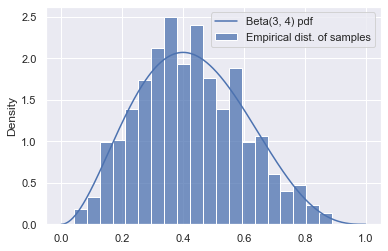

In [38]:
import numpy as np
from scipy import stats

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

distribution = stats.beta(3, 4)

# Compute the exact PDF:
t = np.linspace(0, 1, 500)
pdf = distribution.pdf(t)

# Draw 1000 samples, and look at the empirical distribution of those samples:
samples = distribution.rvs(1000)
f, ax = plt.subplots(1, 1)

sns.histplot(x=samples, stat='density', bins=20, label='Empirical dist. of samples')
ax.plot(t, pdf, label='Beta(3, 4) pdf')
ax.legend()

We can see that the samples are a good representation for the distribution, as long as we have enough. We can use the mean of the samples to approximate the mean of the distribution:

In [39]:
# The mean of a Beta(a, b) distribution is a/(a+b):
true_mean = 3 / (3 + 4)

approx_mean = np.mean(samples)
print(true_mean, approx_mean)

0.42857142857142855 0.42340549237389885


### Rejection Sampling

As a warmup, let's suppose that we want to sample a pair of random variables ($x_1$, $x_2$) drawn uniformly from the unit circle. In other words, we want the uniform distribution over the blue region below:

How can we go about doing this? 

*(Hint: first sample uniformly over the unit square.)*

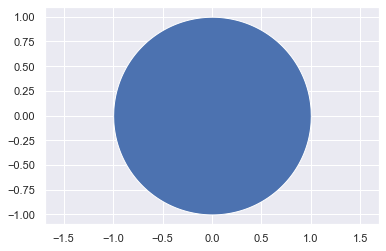

In [12]:
x_ = np.linspace(-1, 1, 1000)
semicircle = np.sqrt(1-x_**2)
plt.fill_between(x_, -semicircle, semicircle)
plt.axis('equal');

In [16]:

# Number of samples
N = 400

# Samples in the unit square
samples = np.random.uniform(-1, 1, [N, 2])


array([[-1.68070104e-01, -3.08630748e-01],
       [ 2.08194998e-01, -4.02121224e-01],
       [ 2.55274575e-01,  4.02137250e-02],
       [-6.04549978e-01, -7.69730186e-01],
       [-5.75684964e-01,  2.89100146e-01],
       [-3.88034849e-01,  5.11002395e-01],
       [-2.05958382e-01, -9.64301322e-01],
       [-1.08031775e-01, -7.60807437e-01],
       [ 1.56908831e-02, -7.34426449e-01],
       [ 1.52923452e-01,  9.26384339e-01],
       [-6.90575468e-01,  1.91299310e-01],
       [ 8.56356233e-01,  9.84994815e-01],
       [-1.36806862e-01, -6.97968119e-01],
       [-8.16571223e-01,  7.22705312e-01],
       [ 8.73380374e-01, -8.21791787e-01],
       [-9.94083508e-01,  4.05530502e-01],
       [ 2.24391915e-01, -3.03334952e-01],
       [-3.13502258e-01,  2.84851690e-01],
       [-5.37362611e-01,  4.05404235e-01],
       [-6.91502438e-01, -6.84504664e-01],
       [ 4.52297687e-01,  9.84151273e-01],
       [ 5.99436648e-01, -6.56571906e-02],
       [ 9.93277172e-01,  5.96203712e-01],
       [-1.

Variance of x1 (estimated from samples): 0.249


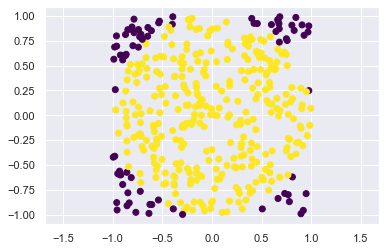

In [18]:

# Number of samples
N = 400

# Samples in the unit square
samples = np.random.uniform(-1, 1, [N, 2])

# Which ones are inside the unit circle?
is_in_circle = (samples[:,0]**2 + samples[:, 1]**2) < 1

plt.figure()
plt.scatter(samples[:, 0], samples[:, 1], c=is_in_circle, cmap='viridis')
plt.axis('equal')

good_samples = samples[is_in_circle]
x1 = good_samples[:, 0]
x2 = good_samples[:, 1]
print('Variance of x1 (estimated from samples): %.3f' % np.var(x1))

Next, let's think about sampling from a distribution with a complicated density. Suppose we want to sample from the distribution with density $p(\theta|x) \propto \theta \cdot (1.5-\theta) \cdot \sin(\theta)$ for $\theta \in [0,1.5]$:

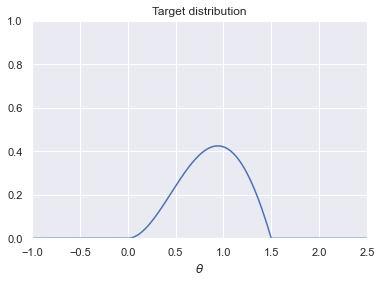

In [23]:
t = np.linspace(-1, 2.5, 500)
def target(t):
    """The unnormalized distribution we want to sample from"""
    return t * (1.5-t) * np.sin(t) * ((t > 0) & (t < 1.5))
plt.plot(t, target(t))
plt.title('Target distribution')
plt.xlabel(r'$\theta$')
plt.axis([-1,2.5,0,1])
plt.show()

How can we make this look like the geometric example from before? Idea: "lifting" (add one dimension).

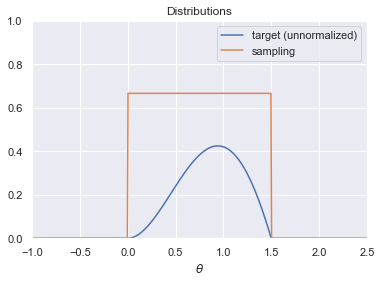

In [24]:
x = np.linspace(-1, 2.5, 500)
def uniform_sampling_dist(t):
    """PDF of distribution we're sampling from: Uniform[0, 1.5]"""
    return stats.uniform.pdf(t, 0, 1.5)

plt.plot(t, target(t), label='target (unnormalized)')
plt.plot(t, uniform_sampling_dist(t), label='sampling')
plt.axis([-1,2.5,0,1])
plt.legend()
plt.title('Distributions')
plt.xlabel(r'$\theta$')
plt.show()

In [25]:
def rejection_sample_uniform(num_samples=100):
    # Generate proposals for samples: these are θ-values.
    # We'll keep some and reject the rest.
    proposals = np.random.uniform(low=0, high=1.5, size=num_samples)
    
    # Acceptance probability is the ratio of the two curves
    # These had better all be between 0 and 1!
    accept_probs = target(proposals) / uniform_sampling_dist(proposals)
    
    print('Max accept prob: %.3f' % np.max(accept_probs))
    
    # For each sample, we make a decision whether or not to accept.
    # Convince yourself that this line makes that decision for each
    # sample with prob equal to the value in "accept_probs"!
    accept = np.random.uniform(size=num_samples) < accept_probs
    
    num_accept = np.sum(accept)
    print('Accepted %d out of %d proposals' % (num_accept, num_samples))
    return proposals[accept]


Max accept prob: 0.638
Accepted 36388 out of 100000 proposals


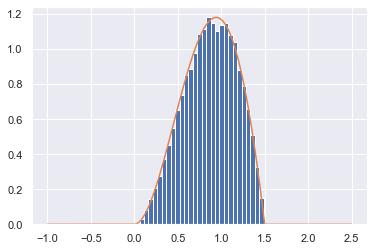

In [30]:
samples = rejection_sample_uniform(num_samples=100000)

# Plot a true histogram (comparable with density functions) using density=True
plt.hist(samples, bins=np.linspace(-0.5, 2, 50), density=True)

# Where did this magic number 0.36 come from? What happens if you change it?
plt.plot(t, target(t) / 0.36)


As a final example, what happens if we want to sample across the entire real line? For instance, suppose our density is $p(\theta|x) \propto \exp(-\theta) |\sin(2\theta)|$ for $\theta \in [0, \infty)$. We certainly can't use a uniform proposal distribution, but using the exponential distribution works just fine.

Accepted 61 out of 100 proposals


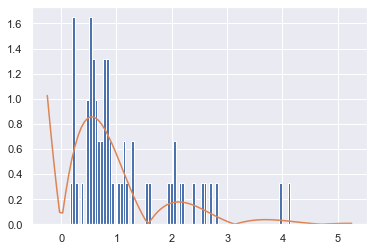

In [11]:
def decaying_target_distribution(t):
    """Unnormalized target distribution as described above"""
    return np.exp(-t) * np.abs(np.sin(2*t))

def sampling_distribution_exponential(t):
    """Sampling distribution: exponential distribution"""
    # stats.expon has a loc parameter which says how far to shift
    # the distribution from its usual starting point of θ=0
    return stats.expon.pdf(t, loc=0, scale=1.0)

def rejection_sample_exponential(num_samples=100):
    proposals = np.random.exponential(scale=1.0, size=num_samples)
    
    accept_probs = decaying_target_distribution(proposals) / sampling_distribution_exponential(proposals)
    accept = np.random.uniform(0, 1, num_samples) < accept_probs
    num_accept = np.sum(accept)
    print('Accepted %d out of %d proposals' % (num_accept, num_samples))
    return proposals[accept]
samples = rejection_sample_exponential(num_samples=100)
plt.hist(samples, bins=np.linspace(0, 5, 100), density=True)
# Find how far the axis goes and draw the unnormalized distribution over it

tmin, tmax, _, _ = plt.axis()
t_inf = np.linspace(tmin, tmax, 100)

# Where did this magic number 0.6 come from? What happens if you change it?
plt.plot(t_inf, decaying_target_distribution(t_inf) / 0.6)
plt.show()

## Implementing models in PyMC3

Let's go back to the simple review model:

$$
\begin{align}
    x_i &\sim \mathrm{Bernoulli}(\theta) \\
    \theta &\sim \mathrm{Beta}(\alpha, \beta)
\end{align}
$$

Is there a way to implement this model computationally and have Python do all the work of inference for us? It turns out the answer is yes!


In [12]:
reviews_a = np.array([1, 1, 1])
reviews_b = np.array([1] * 19 + [0])

In [47]:
import pymc3 as pm
import arviz as az

# Parameters of the prior
alpha = 1
beta = 5

with pm.Model() as model:
    # Define a Beta-distributed random variable called theta
    theta = pm.Beta('theta', alpha=alpha, beta=beta)
    
    # Defines a Bernoulli RV called x. Since x is observed, we
    # pass in the observed= argument to provide our data
    x = pm.Bernoulli('x', p=theta, observed=reviews_b)
    
    # This line asks PyMC3 to approximate the posterior.
    # Don't worry too much about how it works for now.
    trace = pm.sample(2000, chains=2, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 20 seconds.


In [48]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [49]:
trace.posterior

<xarray.Dataset>
Dimensions:  (chain: 2, draw: 2000)
Coordinates:
  * chain    (chain) int64 0 1
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999
Data variables:
    theta    (chain, draw) float64 0.7844 0.8916 0.8954 ... 0.7236 0.7236 0.7548
Attributes:
    created_at:                 2022-02-10T18:32:59.262378
    arviz_version:              0.11.4
    inference_library:          pymc3
    inference_library_version:  3.11.4
    sampling_time:              20.192965269088745
    tuning_steps:               1000

(array([   4.,   21.,   71.,  202.,  437.,  769., 1060.,  846.,  493.,
          97.]),
 array([0.43397207, 0.48652497, 0.53907786, 0.59163076, 0.64418366,
        0.69673656, 0.74928946, 0.80184236, 0.85439526, 0.90694816,
        0.95950106]),
 <BarContainer object of 10 artists>)

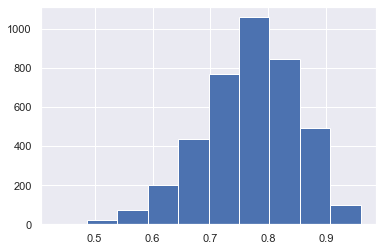

In [53]:
plt.hist(trace.posterior['theta'].values.flatten())

First, we'll need a trick called "fancy indexing". Here's how it works: